<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/jax_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief introduction to JAX 

murphyk@gmail.com.

[JAX](https://github.com/google/jax) is a  version of NumPy that runs fast on CPU, GPU and TPU, by compiling down to XLA. It also has an excellent automatic differentiation library, extending the earlier [autograd](https://github.com/hips/autograd) package, which makes it easy to compute higher order derivatives, gradients of complex functions (e.g., optimize an iterative solver), etc.
The JAX interface is almost identical to NumPy (by design), but with some small differences, and lots of additional features.
We give a brief introduction below. 
For more details, see [this list of JAX tutorials](https://github.com/probml/pyprobml/blob/master/notebooks/jax_tutorials.md).








# Setup

In [ ]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

from functools import partial
import os
import time
import numpy as np
np.set_printoptions(precision=3)
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from typing import Tuple, NamedTuple

from IPython import display
%matplotlib inline

import sklearn


In [ ]:

# Load JAX
import jax
import jax.numpy as jnp

from jax import random, vmap, jit, grad, value_and_grad, hessian, jacfwd, jacrev
print("jax version {}".format(jax.__version__))
# Check the jax backend
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
key = random.PRNGKey(0)

jax version 0.2.9
jax backend gpu


In [ ]:
%%capture
!pip install git+https://github.com/deepmind/dm-haiku
import haiku as hk

In [ ]:
%%capture
!pip install --upgrade -q git+https://github.com/google/flax.git
import flax

# Hardware accelerators

Colab makes it easy to use GPUs and TPUs for speeding up some workflows, especially related to deep learning.

## GPUs

Colab offers graphics processing units (GPUs) which can be much faster than CPUs (central processing units), as we illustrate below.

In [ ]:
# Check if GPU is available and its model, memory ...etc.
!nvidia-smi


Tue Feb  9 13:54:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    40W / 300W |  14549MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

# Check if JAX is using GPU
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
# Check the devices avaiable for JAX
jax.devices()

jax backend gpu


[GpuDevice(id=0)]

Let's see how JAX can speed up things like matrix-matrix multiplication.

First the numpy/CPU version.

In [ ]:
# Parameters for the experiment
size = int(1e3)
number_of_loops=int(1e2)


In [ ]:
# Standard numpy CPU

def f(x=None):
  if not isinstance(x, np.ndarray):
    x=np.ones((size, size), dtype=np.float32) 
  return np.dot(x, x.T)



In [ ]:
%timeit -o -n $number_of_loops f()

100 loops, best of 3: 14.9 ms per loop


<TimeitResult : 100 loops, best of 3: 14.9 ms per loop>

In [ ]:
res = _ # get result of last cell
time_cpu = res.best
print(time_cpu)

0.014857908460000999


Now we look at the JAX version. JAX supports execution on [XLA](https://www.tensorflow.org/xla) devices, which can be CPU, GPU or even TPU. We added that block_until_ready because JAX uses [asynchronous execution](https://jax.readthedocs.io/en/latest/async_dispatch.html) by default.


In [ ]:
# JAX device execution
# https://github.com/google/jax/issues/1598

def jf(x=None): 
  if not isinstance(x, jnp.ndarray):
    x=jnp.ones((size, size), dtype=jnp.float32)
  return jnp.dot(x, x.T)


f_gpu = jit(jf, backend='gpu')
f_cpu = jit(jf, backend='cpu')

In [ ]:
# Time the CPU version

%timeit -o -n $number_of_loops f_cpu() 

100 loops, best of 3: 14.5 ms per loop


<TimeitResult : 100 loops, best of 3: 14.5 ms per loop>

In [ ]:
res = _
time_jcpu = res.best
print(time_jcpu)

0.014495725080000738


In [ ]:
# Time the GPU version

%timeit -o -n $number_of_loops f_gpu().block_until_ready() 

The slowest run took 44.47 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 276 µs per loop


<TimeitResult : 100 loops, best of 3: 276 µs per loop>

In [ ]:
res = _
time_jgpu = res.best
print(time_jgpu)

0.0002756696500000544


In [ ]:
print('JAX CPU time {:0.6f}, Numpy CPU time {:0.6f}, speedup {:0.6f}'.format(
    time_jcpu, time_cpu, time_cpu/time_jcpu))
print('JAX GPU time {:0.6f}, JAX CPU time {:0.6f}, speedup {:0.6f}'.format(
    time_jgpu, time_jcpu, time_jcpu/time_jgpu))
print('JAX GPU time {:0.6f}, Numpy CPU time {:0.6f}, speedup {:0.6f}'.format(
    time_jgpu, time_cpu, time_cpu/time_jgpu))

JAX CPU time 0.014496, Numpy CPU time 0.014858, speedup 1.024986
JAX GPU time 0.000276, JAX CPU time 0.014496, speedup 52.583682
JAX GPU time 0.000276, Numpy CPU time 0.014858, speedup 53.897513


This illustrates the power of XLA (Accelerated Linear Algebra compiler), even for apples to apples comparison of same hardware. JAX can be faster even on a CPU than the standard numpy. Note that due to various factors exectution times can vary per run even on a single machine, however the overall performance of human writtten vs. compiler emitted (i.e. numpy C backend vs. JAX XLA jit backend) is a topic of its own.

We can move numpy arrays to the GPU for speed. The result will be transferred back to CPU for printing, saving, etc.

In [ ]:
from jax import device_put

x = np.ones((size, size)).astype(np.float32)
print(type(x))
%timeit -o -n $number_of_loops f(x)

x = device_put(x)
print(type(x))
%timeit -o -n $number_of_loops jf(x)

<class 'numpy.ndarray'>
100 loops, best of 3: 14.1 ms per loop
<class 'jax.interpreters.xla._DeviceArray'>
100 loops, best of 3: 639 µs per loop


<TimeitResult : 100 loops, best of 3: 639 µs per loop>

## TPUs

We can turn on the tensor processing unit as shown below.
Everything else "just works" as before.

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

# Vmap <a class="anchor" id="vmap"></a>

We often write a function to process a single vector or matrix, and then want to apply it to a batch of data. Using for loops is slow, and manually batchifying code is complex. Fortunately we can use the `vmap` function, which will map our function across a set of inputs, automatically batchifying it.



## Example: 1d convolution

(This example is from the Deepmind tutorial.)

Consider standard 1d convolution of two vectors.


In [ ]:
x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

Now suppose we want to convolve multiple vectors with multiple kernels. The simplest way is to use a for loop, but this is slow.


In [ ]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

manually_batched_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

We can manually vectorize the code, but it is complex.

In [ ]:
def manually_vectorised_convolve(xs, ws):
  output = []
  for i in range(1, xs.shape[-1] -1):
    output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
  return jnp.stack(output, axis=1)

manually_vectorised_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

Fortunately vmap can do this for us!

In [ ]:
auto_batch_convolve = jax.vmap(convolve)

auto_batch_convolve(xs, ws)

DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

## Axes

By default, vmap vectorizes over the first axis of each of its inputs. If the first argument has a batch and the second does not, ,specify `in_axes=[0,None]`, so the second argument is not vectorized over.

In [ ]:
jax.vmap(convolve, in_axes=[0, None])(xs, w)


DeviceArray([[11., 20., 29.],
             [11., 20., 29.]], dtype=float32)

We can also vectorize over other dimensions.

In [ ]:

print(xs.shape)
xst = jnp.transpose(xs)
print(xst.shape)

wst = jnp.transpose(ws)

auto_batch_convolve_v2 = jax.vmap(convolve, in_axes=1, out_axes=1)
auto_batch_convolve_v2(xst, wst)

(2, 5)
(5, 2)


DeviceArray([[11., 11.],
             [20., 20.],
             [29., 29.]], dtype=float32)

## Example: logistic regression

We now give another example, using binary logistic regression.
Let us start with a predictor for a single example
.

In [ ]:

D = 2
N = 3

w = np.random.normal(size=(D,))
X = np.random.normal(size=(N,D))

def sigmoid(x): return 0.5 * (jnp.tanh(x / 2.) + 1)

def predict_single(x):
    return sigmoid(jnp.dot(w, x)) # <(D) , (D)> = (1) # inner product
  
print(predict_single(X[0,:])) # works

print(predict_single(X)) # fails

0.2391612


TypeError: ignored

We can manually vectorize the code by remembering the shapes, so 
$X w$ multiplies each row of $X$ with $w$.

In [ ]:
def predict_batch(X):
    return sigmoid(jnp.dot(X, w)) # (N,D) * (D,1) = (N,1) # matrix-vector multiply

print(predict_batch(X)) 

[0.223 0.636 0.427]


Fortunately we can use vmap.

In [ ]:
print(vmap(predict_single)(X))

[0.223 0.636 0.427]


## Failure cases

Vmap requires that the shapes of all the variables that are created by the function that is being mapped are the same for all values of the input arguments, as explained [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html). So vmap cannot be used to do any kind of embarassingly parallel task. Below we give a simple example of where this fails, since internally we create a vector whose length depends on the input 'length'.

In [ ]:
def example_fun(length, val=4):
  return jnp.sum(jnp.ones((length,)) * val)

xs = jnp.arange(1,10)

# Python map works fine
v = list(map(example_fun, xs))
print(v)

[DeviceArray(4., dtype=float32), DeviceArray(8., dtype=float32), DeviceArray(12., dtype=float32), DeviceArray(16., dtype=float32), DeviceArray(20., dtype=float32), DeviceArray(24., dtype=float32), DeviceArray(28., dtype=float32), DeviceArray(32., dtype=float32), DeviceArray(36., dtype=float32)]


The following fails.

In [ ]:
v = vmap(example_fun)(xs)
print(v)

TypeError: ignored

# Stochastics

JAX is designed to be deterministic, but in some cases, we want to introduce randomness in a controlled way, and to reason about it. We discuss this below

## Random number generation

One of the biggest differences from NumPy is the way Jax treates pseudo random number generation (PRNG).
This is because Jax does not maintain any global state, i.e., it is purely functional.
This design "provides reproducible results invariant to compilation boundaries and backends,
while also maximizing performance by enabling vectorized generation and parallelization across random calls"
(to quote [the official page](https://github.com/google/jax#a-brief-tour)).

For example, consider this Numpy snippet. Each call to np.random.uniform updates the global state. The value of foo() is therefore only guaranteed to give the same result every time if we evaluate bar() and baz() in the same order (eg left to right). This is why foo1 and foo2 give different answers.


In [ ]:
import numpy as np


def bar(): return np.random.uniform(size=(3))
def baz(): return np.random.uniform(size=(3))

def foo(seed): 
  np.random.seed(seed)
  return bar() + 2*baz()

def foo1(seed): 
  np.random.seed(seed)
  a = bar()
  b =  2*baz()
  return a+b

def foo2(seed): 
  np.random.seed(seed)
  a = 2*baz() 
  b = bar()
  return a+b

seed = 0

print(foo(seed))
print(foo1(seed))
print(foo2(seed))

[1.639 1.562 1.895]
[1.639 1.562 1.895]
[1.643 1.854 1.851]




Jax may evaluate parts of expressions such as `bar() + baz()` in parallel, which would violate reproducibility. To prevent this, the user must pass in an explicit PRNG key to every function that requires a source of randomness. Using the same key will give the same results.See the example below.

In [ ]:


key = random.PRNGKey(0)
print(random.normal(key, shape=(3,)))  # [ 1.81608593 -0.48262325  0.33988902]
print(random.normal(key, shape=(3,)))  # [ 1.81608593 -0.48262325  0.33988902]  ## identical results



[ 1.816 -0.483  0.34 ]
[ 1.816 -0.483  0.34 ]


When generating independent samples, it is important to use different keys, to ensure results are not correlated. We can do this by *splitting* the key into the the 'master' key (which will be used in later parts of the code via splitting), and the 'subkey', which is used temporarily to generate randomness and then thrown away, as we illustrate below.

In [ ]:
# To make a new key, we split the current key into two pieces.
key, subkey = random.split(key)
print(random.normal(subkey, shape=(3,)))  # [ 1.1378783  -1.22095478 -0.59153646]

# We can continue to split off new pieces from the global key.
key, subkey = random.split(key)
print(random.normal(subkey, shape=(3,)))  # [-0.06607265  0.16676566  1.17800343]



[ 1.138 -1.221 -0.592]
[-0.066  0.167  1.178]


We now reimplement the numpy example in Jax and show that we get the result no matter the order of evaluation of bar and baz.

In [ ]:

def bar(key): 
  return jax.random.uniform(key,shape=(3,))

def baz(key):
  return jax.random.uniform(key,shape=(3,))

def foo(key): 
  subkey1, subkey2 = random.split(key, num=2) 
  return bar(subkey1) + 2 * baz(subkey2)

def foo1(key): 
  subkey1, subkey2 = random.split(key, num=2) 
  a = bar(subkey1) 
  b =  2 * baz(subkey2)
  return a+b

def foo2(key): 
  subkey1, subkey2 = random.split(key, num=2) 
  a = 2 * baz(subkey2)
  b = bar(subkey1)
  return a+b

key = random.PRNGKey(0)
key, subkey = random.split(key) 
print(foo(subkey))
print(foo1(subkey))
print(foo2(subkey))

[2.079 2.002 1.089]
[2.079 2.002 1.089]
[2.079 2.002 1.089]


In Jax (but not in python),  a random draw of N samples in parallel will not give the same results as N draws of individual samples, as we show below. 

In [ ]:
key = random.PRNGKey(42)
subkeys = random.split(key, 3)
sequence = np.stack([jax.random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(42)
print("all at once: ", jax.random.normal(key, shape=(3,)))

individually: [-0.048  0.108 -1.223]
all at once:  [ 0.187 -1.281 -1.559]


In [ ]:
np.random.seed(0)
sequence = np.stack([np.random.normal() for i in range(3)])
print("individually:", sequence)

np.random.seed(0)
print("all at once: ", np.random.normal(size=(3,)))


individually: [1.764 0.4   0.979]
all at once:  [1.764 0.4   0.979]


Haiku has a handy method for generating a sequence of random keys from a seed key, as we show below.

In [ ]:
import haiku as hk
rng = jax.random.PRNGKey(0)
rng_seq = hk.PRNGSequence(rng)
for i in range(5):
  rng = next(rng_seq)
  samples = jax.random.bernoulli(rng, 0.5, shape=(3,))
  print(samples)

[False  True  True]
[ True False False]
[ True  True  True]
[False False  True]
[ True  True False]


## Probability distributions

*TODO*


# Autograd <a class="anchor" id="AD"></a>

In this section, we illustrate automatic differentation using JAX.
For details, see see  [this video](https://www.youtube.com/watch?v=wG_nF1awSSY&t=697s)  or [The Autodiff Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html).



## Derivatives

We can compute $(\nabla f)(x)$ using `grad(f)(x)`. For example, consider


$f(x) = x^3 + 2x^2 - 3x + 1$

$f'(x) = 3x^2 + 4x -3$

$f''(x) = 6x + 4$

$f'''(x) = 6$

$f^{iv}(x) = 0$



In [ ]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1

dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)
d3fdx = jax.grad(d2fdx)
d4fdx = jax.grad(d3fdx)

print(dfdx(1.))
print(d2fdx(1.))
print(d3fdx(1.))
print(d4fdx(1.))

4.0
10.0
6.0
0.0


## Partial derivatives


$$
\begin{align}
f(x,y) &= x^2 + y \\
\frac{\partial f}{\partial x} &= 2x \\
\frac{\partial f}{\partial y} &= 1 
\end{align}
$$


In [ ]:
def f(x,y):
  return x**2 + y

# Partial derviatives
x = 2.0; y= 3.0;
v, gx = value_and_grad(f, argnums=0)(x,y)
print(v)
print(gx)

gy = grad(f, argnums=1)(x,y)
print(gy)


7.0
4.0
1.0


## Gradients 

Linear function: multi-input, scalar output.

$$
\begin{align}
f(x; a) &= a^T x\\
\nabla_x f(x;a) &= a
\end{align}
$$

In [ ]:


def fun1d(x):
    return jnp.dot(a, x)[0]

Din = 3; Dout = 1;
a = np.random.normal(size=(Dout, Din))
x = np.random.normal(size=(Din,))

g = grad(fun1d)(x)
assert np.allclose(g, a)


# It is often useful to get the function value and gradient at the same time
val_grad_fn = jax.value_and_grad(fun1d)
v, g = val_grad_fn(x)
print(v)
print(g)
assert np.allclose(v, fun1d(x))
assert np.allclose(a, g)


-1.0599848
[-1.311  0.546  0.915]


Linear function: multi-input, multi-output.

$$
\begin{align}
f(x;A) &= A x \\
\frac{\partial f(x;A)}{\partial x} &= A
\end{align}
$$

In [ ]:
# We construct a multi-output linear function.
# We check forward and reverse mode give same Jacobians.


def fun(x):
    return jnp.dot(A, x)

Din = 3; Dout = 4;
A = np.random.normal(size=(Dout, Din))
x = np.random.normal(size=(Din,))
Jf = jacfwd(fun)(x)
Jr = jacrev(fun)(x)
assert np.allclose(Jf, Jr)
assert np.allclose(Jf, A)

Quadratic form.

$$
\begin{align}
f(x;A) &= x^T A x \\
\nabla_x f(x;A) &= (A+A^T) x
\end{align}
$$

In [ ]:

D = 4
A = np.random.normal(size=(D,D))
x = np.random.normal(size=(D,))
quadfun = lambda x: jnp.dot(x, jnp.dot(A, x))

g = grad(quadfun)(x)
assert np.allclose(g, jnp.dot(A+A.T, x))



Chain rule applied to sigmoid function.

$$
\begin{align}
\mu(x;w) &=\sigma(w^T x) \\
\nabla_w \mu(x;w) &= \sigma'(w^T x) x \\
\sigma'(a) &= \sigma(a) * (1-\sigma(a)) 
\end{align}
$$

In [ ]:


D = 4
w = np.random.normal(size=(D,))
x = np.random.normal(size=(D,))
y = 0 

def sigmoid(x): return 0.5 * (jnp.tanh(x / 2.) + 1)
def mu(w): return sigmoid(jnp.dot(w,x))
def deriv_mu(w): return mu(w) * (1-mu(w)) * x
deriv_mu_jax =  grad(mu)

print(deriv_mu(w))
print(deriv_mu_jax(w))

assert np.allclose(deriv_mu(w), deriv_mu_jax(w), atol=1e-3)



[-0.458  0.022 -0.266 -0.005]
[-0.458  0.022 -0.266 -0.005]


## Auxiliary return values

A function can return its value and other auxiliary results; the latter are not differentiated. 

In [ ]:
def f(x,y):
  return x**2+y, 42

(v,aux), g = value_and_grad(f, has_aux=True)(x,y)
print(v)
print(aux)
print(g)

7.0
42
4.0


## Jacobians


Example: Linear function: multi-input, multi-output.

$$
\begin{align}
f(x;A) &= A x \\
\frac{\partial f(x;A)}{\partial x} &= A
\end{align}
$$


In [ ]:
# We construct a multi-output linear function.
# We check forward and reverse mode give same Jacobians.


def fun(x):
    return jnp.dot(A, x)

Din = 3; Dout = 4;
A = np.random.normal(size=(Dout, Din))
x = np.random.normal(size=(Din,))
Jf = jacfwd(fun)(x)
Jr = jacrev(fun)(x)
assert np.allclose(Jf, Jr)

## Hessians

Quadratic form.

$$
\begin{align}
f(x;A) &= x^T A x \\
\nabla_x^2 f(x;A) &= A + A^T
\end{align}
$$

In [ ]:

D = 4
A = np.random.normal(size=(D,D))
x = np.random.normal(size=(D,))

quadfun = lambda x: jnp.dot(x, jnp.dot(A, x))


H1 = hessian(quadfun)(x)
assert np.allclose(H1, A+A.T)

def my_hessian(fun):
  return jacfwd(jacrev(fun))

H2 = my_hessian(quadfun)(x)
assert np.allclose(H1, H2)

## Example: Binary logistic regression

In [ ]:

def sigmoid(x): return 0.5 * (jnp.tanh(x / 2.) + 1)

def predict_single(w, x):
    return sigmoid(jnp.dot(w, x)) # <(D) , (D)> = (1) # inner product
  
def predict_batch(w, X):
    return sigmoid(jnp.dot(X, w)) # (N,D) * (D,1) = (N,1) # matrix-vector multiply

# negative log likelihood
def loss(weights, inputs, targets):
    preds = predict_batch(weights, inputs)
    logprobs = jnp.log(preds) * targets + jnp.log(1 - preds) * (1 - targets)
    return -jnp.sum(logprobs)


D = 2
N = 3
w = jax.random.normal(key, shape=(D,))
X = jax.random.normal(key, shape=(N,D))
y = jax.random.choice(key, 2, shape=(N,)) # uniform binary labels
#logits = jnp.dot(X, w)
#y = jax.random.categorical(key, logits)

print(loss(w, X, y))

# Gradient function
grad_fun = grad(loss)

# Gradient of each example in the batch - 2 different ways
grad_fun_w = partial(grad_fun, w)
grads = vmap(grad_fun_w)(X,y)
print(grads)
assert grads.shape == (N,D)

grads2 = vmap(grad_fun, in_axes=(None, 0, 0))(w, X, y) 
assert np.allclose(grads, grads2)

# Gradient for entire batch
grad_sum = jnp.sum(grads, axis=0)
assert grad_sum.shape == (D,)
print(grad_sum)

1.5545294
[[ 0.042 -0.287]
 [-0.236 -0.454]
 [-0.14   0.067]]
[-0.334 -0.673]


In [ ]:
# Textbook implementation of gradient
def NLL_grad(weights, batch):
    X, y = batch
    N = X.shape[0]
    mu = predict_batch(weights, X)
    g = jnp.sum(jnp.dot(jnp.diag(mu - y), X), axis=0)
    return g

grad_sum_batch = NLL_grad(w, (X,y))
print(grad_sum_batch)
assert np.allclose(grad_sum, grad_sum_batch)

[-0.334 -0.673]


In [ ]:
# We can also compute Hessians, as we illustrate below.

hessian_fun = hessian(loss)

# Hessian on one example
H0 = hessian_fun(w, X[0,:], y[0])
print('Hessian(example 0)\n{}'.format(H0))

# Hessian for batch
Hbatch = vmap(hessian_fun, in_axes=(None, 0, 0))(w, X, y) 
print('Hbatch shape {}'.format(Hbatch.shape))

Hbatch_sum = jnp.sum(Hbatch, axis=0)
print('Hbatch sum\n {}'.format(Hbatch_sum))

Hessian(example 0)
[[ 0.006 -0.042]
 [-0.042  0.286]]
Hbatch shape (3, 2, 2)
Hbatch sum
 [[0.118 0.139]
 [0.139 0.65 ]]


In [ ]:
# Textbook implementation of Hessian

def NLL_hessian(weights, batch):
  X, y = batch
  mu = predict_batch(weights, X)
  S = jnp.diag(mu * (1-mu))
  H = jnp.dot(jnp.dot(X.T, S), X)
  return H

H2 = NLL_hessian(w, (X,y) )

assert np.allclose(Hbatch_sum, H2, atol=1e-2)

## Vector Jacobian Products (VJP) and Jacobian Vector Products (JVP)

Consider a bilinear mapping $f(x,W) = x W$.
For fixed parameters, we have
$f1(x) = W x$, so $J(x) = W$, and $u^T J(x) = J(x)^T u = W^T u$.


In [ ]:
n = 3; m = 2;
W = jax.random.normal(key, shape=(m,n))
x = jax.random.normal(key, shape=(n,))
u = jax.random.normal(key, shape=(m,))

def f1(x): return jnp.dot(W,x)

J1 = jacfwd(f1)(x)
print(J1.shape)

assert np.allclose(J1, W)
tmp1 = jnp.dot(u.T, J1)
print(tmp1)

(val, jvp_fun) = jax.vjp(f1, x)

tmp2 = jvp_fun(u)

assert np.allclose(tmp1, tmp2)

tmp3 = np.dot(W.T, u)
assert np.allclose(tmp1, tmp3)




(2, 3)
[ 0.922  1.216 -0.61 ]


For fixed inputs, we have
$f2(W) = W x$, so $J(W) = \text{something complex}$,
but $u^T J(W) = J(W)^T u = u x^T$.

In [ ]:

def f2(W): return jnp.dot(W,x)

J2 = jacfwd(f2)(W)
print(J2.shape)

tmp1 = jnp.dot(u.T, J2)
print(tmp1)
print(tmp1.shape)

(val, jvp_fun) = jax.vjp(f2, W)
tmp2 = jvp_fun(u)
assert np.allclose(tmp1, tmp2)

tmp3 = np.outer(u, x)
assert np.allclose(tmp1, tmp3)


(2, 2, 3)
[[-1.425  0.379 -0.267]
 [ 1.555 -0.413  0.291]]
(2, 3)


## Stop-gradient

Sometimes we want to take the gradient of a complex expression wrt some parameters $\theta$, but treating $\theta$ as a constant for some parts of the expression. For example, consider the TD(0) update in reinforcement learning, which as the following form:


$\Delta \theta = (r_t + v_{\theta}(s_t) - v_{\theta}(s_{t-1})) \nabla v_{\theta}(s_{t-1})$

where $s$ is the state, $r$ is the reward, and $v$ is the value function.
This update is not the gradient of any loss function.
However it can be **written** as the gradient of the pseudo loss function

$L(\theta) = [r_t + v_{\theta}(s_t) - v_{\theta}(s_{t-1})]^2$

since

$\nabla_{\theta} L(\theta) = 2 [r_t + v_{\theta}(s_t) - v_{\theta}(s_{t-1})] \nabla v_{\theta}(s_{t-1})$

if the dependency of the target $r_t + v_{\theta}(s_t)$ on the parameter $\theta$ is ignored. We can implement this in JAX using `stop_gradient`, as we show below.



In [ ]:
def td_loss(theta, s_prev, r_t, s_t):
  v_prev = value_fn(theta, s_prev)
  target = r_t + value_fn(theta, s_t)
  return 0.5*(jax.lax.stop_gradient(target) - v_prev) ** 2

td_update = jax.grad(td_loss)

# An example transition.
s_prev = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

# Value function and initial parameters
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

print(td_update(theta, s_prev, r_t, s_t))



[-1.2 -2.4  1.2]


## Straight through estimator

The straight-through estimator is a trick for defining a 'gradient' of a function that is otherwise non-differentiable. Given a non-differentiable function $f : \mathbb{R}^n \to \mathbb{R}^n$ that is used as part of a larger function that we wish to find a gradient of, we simply pretend during the backward pass that $f$ is the identity function, so gradients pass through $f$ ignoring the $f'$ term. This can be implemented neatly using `jax.lax.stop_gradient`.

Here is an example of a non-differentiable function that converts a soft probability distribution to a one-hot vector (discretization).


In [ ]:
def onehot(labels, num_classes):
  y = (labels[..., None] == jnp.arange(num_classes)[None])
  return y.astype(jnp.float32)

def quantize(y_soft): 
  y_hard = onehot(jnp.argmax(y_soft), 3)[0]
  return y_hard

y_soft = np.array([0.1, 0.2, 0.7])
print(quantize(y_soft))




[0. 0. 1.]


Now suppose we define some linear function of the quantized variable of the form $f(y) = w^T q(y)$. If $w=[1,2,3]$ and $q(y)=[0,0,1]$, we get $f(y) = 3$. But the gradient is 0 because $q$ is not differentiable.


In [ ]:
def f(y):
  w = jnp.array([1,2,3])
  yq = quantize(y)
  return jnp.dot(w, yq)

print(f(y_soft))
print(grad(f)(y_soft))



3.0
[0. 0. 0.]


To use the straight-through estimator, we replace $q(y)$ with 
$$y + SG(q(y)-y)$$, where SG is stop gradient. In the forwards pass, we have $y+q(y)-y=q(y)$. In the backwards pass, the gradient of SG is 0, so we effectively replace $q(y)$ with $y$. So in the backwarsd pass we have
$$
\begin{align}
f(y) &= w^T q(y) \approx w^T  y \\
\nabla_y f(y) &\approx w
\end{align}
$$

In [ ]:


def f_ste(y):
  w = jnp.array([1,2,3])
  yq = quantize(y)
  yy = y + jax.lax.stop_gradient(yq - y) # gives yq on fwd, and y on backward
  return jnp.dot(w, yy)

print(f_ste(y_soft))
print(grad(f_ste)(y_soft))

3.0
[1. 2. 3.]


## Per-example gradients

In some applications, we want to compute the gradient for every example in a batch, not just the sum of gradients over the batch. This is hard in other frameworks like TF and PyTorch but easy in JAX, as we show below.

In [ ]:
def loss(w, x):
  return jnp.dot(w,x)

w = jnp.ones((3,))
x0 = jnp.array([1.0, 2.0, 3.0])
x1 = 2*x0
X = jnp.stack([x0, x1])
print(X.shape)

perex_grads = jax.jit(jax.vmap(jax.grad(loss), in_axes=(None, 0)))
print(perex_grads(w, X))


(2, 3)
[[1. 2. 3.]
 [2. 4. 6.]]


To explain the above code in more depth, note that the vmap converts the function loss to take  a batch of inputs for each of its arguments, and returns a batch of outputs. To make it work with a single weight vector, we specify in_axes=(None,0), meaning the first argument (w) is not replicated, and the second argument (x) is replicated along dimension 0. 

In [ ]:
gradfn = jax.grad(loss)

W = jnp.stack([w, w])
print(jax.vmap(gradfn)(W, X))

print(jax.vmap(gradfn, in_axes=(None,0))(w, X))



[[1. 2. 3.]
 [2. 4. 6.]]
[[1. 2. 3.]
 [2. 4. 6.]]



# JIT (just in time compilation) <a class="anchor" id="JIT"></a>

In this section, we illustrate how to use the Jax JIT compiler to make code go faster (even on a CPU). However, it does not work on arbitrary Python code, as we explain below.




In [ ]:


def slow_f(x):
  # Element-wise ops see a large benefit from fusion
  return x * x + x * 2.0

x = jnp.ones((5000, 5000))
%timeit  slow_f(x) 

fast_f = jit(slow_f)
%timeit fast_f(x)  
 
assert np.allclose(slow_f(x), fast_f(x))

The slowest run took 242.68 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 1.42 ms per loop
The slowest run took 149.09 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 506 µs per loop


We can also add the `@jit` decorator in front of a function.



In [ ]:
@jit
def faster_f(x):
  return x * x + x * 2.0
  
%timeit faster_f(x)
assert np.allclose(faster_f(x), fast_f(x))  

The slowest run took 35.82 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 507 µs per loop


## How it works: Jaxprs and tracing

In this section, we briefly explain the mechanics behind JIT, which will help you understand when it does not work.

First, consider this function.

In [ ]:

def f(x):
  y = jnp.ones((1,5)) * x
  return y



When a function is first executed (applied to an argument), it is converted to an intermediate representatio called a JAX expression or jaxpr, by a process called tracing, as we show below.

In [ ]:
print(f(3.0))
print(jax.make_jaxpr(f)(3.0))

[[3. 3. 3. 3. 3.]]
{ lambda  ; a.
  let b = broadcast_in_dim[ broadcast_dimensions=(  )
                            shape=(1, 5) ] 1.0
      c = mul b a
  in (c,) }


The XLA JIT compiler can then convert the jaxpr to code that runs fast on a CPU, GPU or TPU; the original python code is no longer needed.

In [ ]:
f_jit = jit(f)
print(f_jit(3.0))

[[3. 3. 3. 3. 3.]]


However, the jaxpr is created by tracing the function for a specific value. If different code is executed depending on the value of the input arguments, the resulting jaxpr will be different, so the function cannot be JITed, as we illustrate below. 

In [ ]:

def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

print(f(3.0))

f_jit = jit(f)
print(f_jit(3.0))

3.0


ConcretizationTypeError: ignored

Jit will create a new compiled version for each different ShapedArray, but will reuse the code for different values of the same shape. If the code path depends on the concrete value,  we can either just jit a subfunction (whose code path is constant), or we can create a different jaxpr for each concrete value of the input arguments as we explain below.



## Static argnum

Note that JIT compilation requires that the control flow through the function  can be determined by the shape (but not concrete value) of its inputs. The function below violates this, since when x<0, it takes one branch, whereas when x>0, it takes the other.

In [ ]:
@jit
def f(x):
  if x > 0:
    return x
  else:
    return 2 * x


# This will fail!
try:
  print(f(3))
except Exception as e:
  print("ERROR:", e)
  


ERROR: Abstract tracer value encountered where concrete value is expected.

The problem arose with the `bool` function. 

While tracing the function f at <ipython-input-17-94e6eda28128>:1, this concrete value was not available in Python because it depends on the value of the arguments to f at <ipython-input-17-94e6eda28128>:1 at flattened positions [0], and the computation of these values is being staged out (that is, delayed rather than executed eagerly).

You can use transformation parameters such as `static_argnums` for `jit` to avoid tracing particular arguments of transformed functions, though at the cost of more recompiles.

See https://jax.readthedocs.io/en/latest/faq.html#abstract-tracer-value-encountered-where-concrete-value-is-expected-error for more information.

Encountered tracer value: Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=0/1)>


We can fix this by telling JAX to trace the control flow through the function using concrete values of some of its arguments. JAX will then compile different versions, depending on the input values. See below for an example.


In [ ]:


def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

f = jit(f, static_argnums=(0,))

print(f(3))



3


In [ ]:
@partial(jit, static_argnums=(0,))
def f(x):
  if x > 0:
    return x
  else:
    return 2 * x
print(f(3))

3


## Jit and vmap

Unfortunately, the static argnum method fails when the function is passed to  vmap, because the latter can take arguments of different shape.

In [ ]:
xs = jnp.arange(5)

@partial(jit, static_argnums=(0,))
def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

ys = vmap(f)(xs)

ValueError: ignored

In [ ]:
def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

xs = jnp.arange(5)
ys = jit(vmap(f)(xs))
print(ys)

ConcretizationTypeError: ignored

## Side effects

Since the jaxpr is created only once, if your function has global side-effects, such as using print, they will only happen once, even if the function is called multiple times. See example below.


In [ ]:
def f(x):
  print('x', x)
  y = 2 * x
  print('y', y)
  return y

y1 = f(2)
print('f', y1)
print('\ncall function a second time')
y1 = f(2)
print('f', y1)

print('\njit version follows')
@jit
def f(x):
  print('x', x)
  y = 2 * x
  print('y', y)
  return y
y2 = f(2)
print('f', y2)

print('\ncall jitted function a second time')
y2 = f(2)
print('f', y2)

x 2
y 4
f 4

call function a second time
x 2
y 4
f 4

jit version follows
x Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
y Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=0/1)>
f 4

call jitted function a second time
f 4


## Caching

If you write `f=jax.jit(g)`, then g will get compiled and the XLA code will be cahced. Subsequent calls to f reuse the cached code for speed. But if the jit is called inside a loop, it is effectively making a new f each time, which is slow.

Also, if you specify static_argnums,hen the cached code will be used only for the same values of arguments labelled as static. If any of them change, recompilation occurs. 


## Strings

Jit does not work with functions that consume or return strings.

In [ ]:
def f(x: int, y: str):
  if y=='add':
    return x+1
  else:
    return x-1

print(f(42, 'add'))
print(f(42, 'sub'))

fj = jax.jit(f)
print(fj(42, 'add'))


43
41


TypeError: ignored

# Pytrees

A Pytree is a container of leaf elements and/or more pytrees. Containers include lists, tuples, and dicts. A leaf element is anything that’s not a pytree, e.g. an array.
Pytrees are useful for representing hierarchical sets of parameters for DNNs (and other structured dsta). 


## Simple example

In [ ]:
from jax import tree_util

# a simple pytree
t1 = [1, {"k1": 2, "k2": (3, 4)}, 5]
print('tree', t1)
leaves = jax.tree_leaves(t1)
print('num leaves', len(leaves))

t4 = [jnp.array([1, 2, 3]), "foo"]
print('tree', t4)
leaves = jax.tree_leaves(t4)
print('num leaves', len(leaves))



tree [1, {'k1': 2, 'k2': (3, 4)}, 5]
num leaves 5
tree [DeviceArray([1, 2, 3], dtype=int32), 'foo']
num leaves 2


## Treemap


We can map functions down a pytree in the same way that we can map a function down a list. We can also combine elements in two pytrees that have the same shape to make a third pytree.

In [ ]:
t1 = [1, {"k1": 2, "k2": (3, 4)}, 5]
print(t1)

t2 = tree_util.tree_map(lambda x: x*x, t1)
print('square each element', t2)


t3 = tree_util.tree_multimap(lambda x,y: x+y, t1, t2)
print('t1+t2', t3)

[1, {'k1': 2, 'k2': (3, 4)}, 5]
square each element [1, {'k1': 4, 'k2': (9, 16)}, 25]
t1+t2 [2, {'k1': 6, 'k2': (12, 20)}, 30]


If we have a list of dicts, we can convert to a dict of lists, as shown below.

In [ ]:

data = [dict(t=1, obs='a', val=-1), dict(t=2, obs='b', val=-2), dict(t=3, obs='c', val=-3)]

data2 = jax.tree_multimap(lambda d0, d1, d2: list((d0, d1, d2)),
                          data[0], data[1], data[2])
print(data2)

def join_trees(list_of_trees):
  d = jax.tree_multimap(lambda *xs: list(xs), *list_of_trees)
  return d

print(join_trees(data))

{'obs': ['a', 'b', 'c'], 't': [1, 2, 3], 'val': [-1, -2, -3]}
{'obs': ['a', 'b', 'c'], 't': [1, 2, 3], 'val': [-1, -2, -3]}


## Flattening


In [ ]:

t1 = [1, {"k1": 2, "k2": (3, 4)}, 5]
leaves, foo = jax.tree_util.tree_flatten(t1)
print(leaves)
print(foo)

[1, 2, 3, 4, 5]
PyTreeDef(list, [*,PyTreeDef(dict[['k1', 'k2']], [*,PyTreeDef(tuple, [*,*])]),*])


## Example: Linear regression 

In this section we show how to use pytrees as a container for parameters of a linear reregression model. 
The code is based on the [flax JAX tutorial](https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html). When we compute the gradient, it will also be a pytree, and will have the same shape as the parameters, so we can add the params to the gradient without having to flatten and unflatten the parameters.

In [ ]:


# Create the predict function from a set of parameters
def make_predict_pytree(params):
  def predict(x):
    return jnp.dot(params['W'],x)+params['b']
  return predict

# Create the loss from the data points set
def make_mse_pytree(x_batched,y_batched): # returns fn(params)->real
  def mse(params):
    # Define the squared loss for a single pair (x,y)
    def squared_error(x,y):
      y_pred = make_predict_pytree(params)(x)
      return jnp.inner(y-y_pred,y-y_pred)/2.0
    # We vectorize the previous to compute the average of the loss on all samples.
    return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)
  return jax.jit(mse) # And finally we jit the result.

In [ ]:
# Set problem dimensions
N = 20
xdim = 10
ydim = 5

# Generate random ground truth W and b
key = random.PRNGKey(0)
Wtrue = random.normal(key, (ydim, xdim))
btrue = random.normal(key, (ydim,))
params_true = {'W': Wtrue, 'b': btrue}
true_predict_fun = make_predict_pytree(params_true)

# Generate data with additional observation noise
X = random.normal(key, (N, xdim))
Ytrue = jax.vmap(true_predict_fun)(X)
Y = Ytrue + 0.1*random.normal(key, (N, ydim))

# Generate MSE for our samples
mse_fun = make_mse_pytree(X, Y)

In [ ]:
# Initialize estimated W and b with zeros.
params = {'W': jnp.zeros_like(Wtrue), 'b': jnp.zeros_like(btrue)}

mse_pytree = make_mse_pytree(X, Y)
print(mse_pytree(params_true))
print(mse_pytree(params))
print(jax.grad(mse_pytree)(params))

0.022292046
24.97824
{'W': DeviceArray([[-0.039,  0.755,  0.542,  0.36 ,  0.224,  1.651,  1.534,
              -1.342, -0.15 , -1.638],
             [-0.324,  0.141, -0.402,  0.498,  1.829,  4.308,  2.138,
              -2.43 , -0.381, -2.178],
             [ 1.7  , -0.707, -0.656, -0.568,  1.824, -2.194, -0.477,
               0.96 ,  1.622,  1.408],
             [-0.862,  0.321, -0.388, -0.74 , -0.82 ,  0.441,  0.772,
              -1.713, -1.592, -0.557],
             [ 1.338, -0.632, -0.968, -1.127,  1.775,  0.323,  1.405,
              -0.638,  1.077, -0.739]], dtype=float32), 'b': DeviceArray([ 0.036,  1.092, -0.413, -1.389, -0.862], dtype=float32)}


In [ ]:
alpha = 0.3 # Gradient step size
print('Loss for "true" W,b: ', mse_pytree(params_true))
for i in range(101):
  gradients = jax.grad(mse_pytree)(params)
  params = jax.tree_multimap(lambda old,grad: old-alpha*grad, params, gradients)
  if (i%10==0):
    print("Loss step {}: ".format(i), mse_pytree(params))



Loss for "true" W,b:  0.022292046
Loss step 0:  6.559746
Loss step 10:  0.17232792
Loss step 20:  0.04339735
Loss step 30:  0.024473606
Loss step 40:  0.017078906
Loss step 50:  0.013489485
Loss step 60:  0.011695381
Loss step 70:  0.01079526
Loss step 80:  0.010343453
Loss step 90:  0.010116666
Loss step 100:  0.0100028105


In [ ]:
print(jax.tree_multimap(lambda x,y: np.allclose(x,y, atol=1e-1), params, params_true))

{'W': True, 'b': True}


Compare the above to what the training code would look like
if W and b were passed in as separate arguments:
```
for i in range(101):
  grad_W = jax.grad(mse_fun,0)(What,bhat)
  grad_b = jax.grad(mse_fun,1)(What,bhat)
  What = What - alpha*grad_W
  bhat = bhat - alpha*grad_b 
  if (i%10==0):
    print("Loss step {}: ".format(i), mse_fun(What,bhat)
```

## Example: MLPs

We now show a more interesting example, from the Deepmind tutorial, where we fit an MLP using SGD. The basic structure is similar to the linear regression case.


In [ ]:
# define the model 
def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

In [ ]:
# MLP with 2 hidden layers and linear output
np.random.seed(0)
params = init_mlp_params([1, 128, 128, 1])
jax.tree_map(lambda x: x.shape, params)


[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

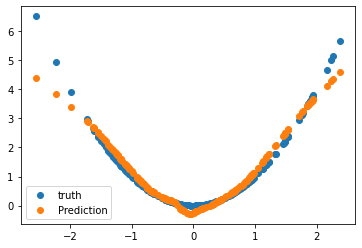

In [ ]:
LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):
  grads = jax.grad(loss_fn)(params, x, y)
  return jax.tree_multimap(
      lambda p, g: p - LEARNING_RATE * g, params, grads)

np.random.seed(0)
xs = np.random.normal(size=(200, 1))
ys = xs ** 2

for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys, label='truth')
plt.scatter(xs, forward(params, xs), label='Prediction')
plt.legend()

# Looping constructs

For loops in Python are slow, even when JIT-compiled. However, there are built-in primitives for loops that are fast, as we illustrate below.

## For loops.

The semantics of the for loop function in JAX is as follows:
```
def fori_loop(lower, upper, body_fun, init_val):
  val = init_val
  for i in range(lower, upper):
    val = body_fun(i, val)
  return val
```
We see that ```val``` is used to accumulate the results across iterations.

Below is an example.

In [ ]:
# sum from 1 to N = N*(N+1)/2

def sum_exact(N):
  return int(N*(N+1)/2)

def sum_slow(N):
  s = 0
  for i in range(1,N+1):
    s += i
  return s

N = 10

assert sum_slow(N) == sum_exact(N)

def sum_fast(N):
  s = jax.lax.fori_loop(1, N+1, lambda i,partial_sum: i+partial_sum, 0)
  return s

assert sum_fast(N) == sum_exact(N) 

In [ ]:
N = 1000
%timeit sum_slow(N)
%timeit sum_fast(N)

10000 loops, best of 3: 44.1 µs per loop
10 loops, best of 3: 41 ms per loop


In [ ]:
N = 100000
%timeit sum_slow(N)
%timeit sum_fast(N)

100 loops, best of 3: 5.04 ms per loop
1 loop, best of 3: 2.88 s per loop


In [ ]:
# Let's do more compute per step of the for loop

D = 10
X = jax.random.normal(key, shape=(D,D))

def sum_slow(N):
  s = jnp.zeros_like(X)
  for i in range(1,N+1):
    s += jnp.dot(X, X)
  return s

def sum_fast(N):
  s = jnp.zeros_like(X)
  s = jax.lax.fori_loop(1, N+1, lambda i,s: s+jnp.dot(X,X), s)
  return s

N = 10
assert np.allclose(sum_fast(N), sum_slow(N))

In [ ]:
N = 1000
%timeit sum_slow(N)
%timeit sum_fast(N)

1 loop, best of 3: 482 ms per loop
10 loops, best of 3: 46.3 ms per loop


## While loops

Here is the semantics of the JAX while loop


```
def while_loop(cond_fun, body_fun, init_val):
  val = init_val
  while cond_fun(val):
    val = body_fun(val)
  return val
```

Below is an example.

In [ ]:


def sum_slow_while(N):
  s = 0
  i = 0
  while (i <= N):
    s += i
    i += 1
  return s


def sum_fast_while(N):
  init_val = (0,0)
  def cond_fun(val):
    s,i = val
    return i<=N
  def body_fun(val):
    s,i = val
    s += i
    i += 1
    return (s,i)
  val = jax.lax.while_loop(cond_fun, body_fun, init_val)
  s2 = val[0]
  return s2

N = 10
assert sum_slow_while(N) == sum_exact(N)
assert sum_slow_while(N) == sum_fast_while(N)

# Common gotchas

## Handling state

In this section, we discuss how to transform code that uses object-oriented programming (which can be stateful) to pure functional programming, which is stateless, as required by JAX. Our presentation is based on the Deepmind tutorial.






To start, consider a simple class that maintains an internal counter, and when called, increments the counter and returns the next number from some sequence. 

In [ ]:
#import string
#DICTIONARY = list(string.ascii_lowercase)
SEQUENCE = jnp.arange(0,100,2)

class Counter:

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    #res = DICTIONARY[self.n]
    res = SEQUENCE[self.n]
    self.n += 1
    return res

  def reset(self):
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

0
2
4


The trouble with the above code is that the call to `count` depends on the internal state of the object (the value `n`), even though this is not an argument to the function. (The code is therefoe said to violate 'referential transparency'.) When we Jit compile it, Jax will only call the code once (to convert to a jaxpr), so the side effect of updating `n` will not happen, resulting in incorrect behavior, as we show below,

In [ ]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

0
0
0


We can solve this problem by passing the state as an argument into the function.

In [ ]:
CounterState = int
Result = int

class CounterV2:

  def count(self, n: CounterState) -> Tuple[Result, CounterState]:
    return SEQUENCE[n], n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

0
2
4


This version is functionally pure, so jit-compiles nicely.

In [ ]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

0
2
4



We can apply the same process to any stateful method to convert it into a stateless one. We took a class of the form

```
class StatefulClass

  state: State

  def stateful_method(*args, **kwargs) -> Output:
```

and turned it into a class of the form

```
class StatelessClass

  def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

This is a common [functional programming](https://en.wikipedia.org/wiki/Functional_programming) pattern, and, essentially, is the way that state is handled in all JAX programs (as we saw with the way Jax handles random number state, or parameters of a model that get updated).
Note that the stateless version of the code no longer needs to use a class, but can instead group the functions into a common namespace using modules.

In some cases (eg when working with DNNs), it is more convenient to write code in an OO way. There are several libraries (notably [Flax](https://github.com/google/flax) and [Haiku](https://github.com/deepmind/dm-haiku))  that let you define a model in an OO way, and then generate functionally pure code. 

## Mutation of arrays 

Since JAX is functional, you cannot mutate arrays in place,
since this makes program analysis and transformation very difficult. JAX requires a pure functional expression of a numerical program.
Instead, JAX offers the functional update functions: `index_update`, `index_add`, `index_min`, `index_max`, and the `index` helper. These are illustrated below. 

Note: If the input values of `index_update` aren't reused, jit-compiled code will perform these operations in-place, rather than making a copy. 
    

In [ ]:
# You cannot assign directly to elements of an array.

A = jnp.zeros((3,3), dtype=np.float32)

# In place update of JAX's array will yield an error!
try:
  A[1, :] = 1.0
except:
  print('must use index_update')

must use index_update


In [ ]:
from jax.ops import index, index_add, index_update

D = 3
A = 2*jnp.ones((D,D))
print("original array:")
print(A)

A2 = index_update(A, index[1, :], 42.0) # A[1,:] = 42
print("original array:")
print(A) # unchanged
print("new array:")
print(A2)

A3 = A.at[1,:].set(42.0) # A3=np.copy(A),  A3[1,:] = 42
print("original array:")
print(A) # unchanged
print("new array:")
print(A3)

A4 = A.at[1,:].mul(42.0) # A4=np.copy(A),  A4[1,:] *= 42
print("original array:")
print(A) # unchanged
print("new array:")
print(A4)



original array:
[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]
original array:
[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]
new array:
[[ 2.  2.  2.]
 [42. 42. 42.]
 [ 2.  2.  2.]]
original array:
[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]
new array:
[[ 2.  2.  2.]
 [42. 42. 42.]
 [ 2.  2.  2.]]
original array:
[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]
new array:
[[ 2.  2.  2.]
 [84. 84. 84.]
 [ 2.  2.  2.]]


## Implicitly casting lists to vectors

You cannot treat a list of numbers as a vector. Instead you must explicitly create the vector using the np.array() constructor.


In [ ]:
# You cannot treat a list of numbers as a vector. 
try:
  S = jnp.diag([1.0, 2.0, 3.0])
except:
  print('must convert indices to np.array')

must convert indices to np.array


In [ ]:
# Instead you should explicitly construct the vector.

S = jnp.diag(jnp.array([1.0, 2.0, 3.0]))